Bot testbed by Arseny

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from copy import deepcopy
import json

import draftsimtools as ds

In [2]:
# Load M19 drafts
raw_drafts = ds.load_drafts("../../data/m19_2.csv")

In [3]:
# Here other folks load card lists, but I grab them from json instead
# m19_set = ds.create_set("data/m19_rating.tsv", "data/m19_land_rating.tsv")

with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON['M19']['cards']

thisSet = {card['name'] : card for card in jsonSubset}

In [ ]:
# One (simple) way to create a list of names:
# nameList = pd.DataFrame(thisSet.keys(),columns = ['Name']) # Instead of relying on cvs, get names from json

In [4]:
# Another (fancier) way to create a list of names + lots of other useful stuff
nameList = pd.DataFrame.from_dict(thisSet, orient='index', columns=['colors','rarity','type','convertedManaCost'])
nameList['Name'] = nameList.index                 # We need names as a column, not an index
nameList['index'] = range(len(nameList))
nameList = nameList.set_index('index')     # And we need a normal numerical index
nameList[1:5]

,colors,rarity,type,convertedManaCost,Name
index,,,,,
1,[R],common,Sorcery,3.0,Act of Treason
2,[W],uncommon,Instant,2.0,Aegis of the Heavens
3,"[U, W]",uncommon,Creature — Human Artificer,4.0,Aerial Engineer
4,[U],uncommon,Enchantment — Aura,2.0,Aether Tunnel


In [5]:
# Process names, then handle weird card names (those with commas)

nameList['Name'] = nameList.Name.str.replace(' ','_')

# This utility method searches for "Name" column in nameList that have commas
nameList, raw_drafts = ds.fix_commas(nameList, raw_drafts) # Returns a tuple, as it updates both
# nameList.Name[nameList.Name.str.find(',')!=-1] # There should be no longer any cards with commas

In [6]:
# Process the drafts, deconstructing packs (hands) at every turn of every draft
drafts = ds.process_drafts(raw_drafts)

Processing draft: 0.
Processing draft: 10000.
Processing draft: 20000.
Processing draft: 30000.
Processing draft: 40000.
Processing draft: 50000.
Processing draft: 60000.
Processing draft: 70000.
Processing draft: 80000.
Processing draft: 90000.
Processing draft: 100000.


### Make sure all cards are listed, even weird foils

In [7]:
# Make sure all cards are listed in the nameList; update if necessary
for iDraft in range(200): #range(len(subset_drafts)):
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft]
    for pack in draft:     
        for cardName in pack:
            try:
                pos = nameList[nameList.Name==cardName].index[0]
            except:
                print("---Unrecognized card: ",cardName) # All unrecognized cards here seem to be foil lands
                #  	colors 	rarity 	type 	convertedManaCost 	Name
                nameList = nameList.append({'colors':[],'rarity':'weird','type':'weird',
                                            'convertedManaCost':0,'Name':cardName},ignore_index=True)

---Unrecognized card:  Island_1
---Unrecognized card:  Mountain_4
---Unrecognized card:  Forest_4
---Unrecognized card:  Plains_2
---Unrecognized card:  Mountain_2
---Unrecognized card:  Forest_2
---Unrecognized card:  Swamp_1
---Unrecognized card:  Mountain_3
---Unrecognized card:  Forest_1
---Unrecognized card:  Island_4
---Unrecognized card:  Swamp_3
---Unrecognized card:  Plains_1
---Unrecognized card:  Swamp_4
---Unrecognized card:  Plains_4
---Unrecognized card:  Forest_3
---Unrecognized card:  Island_3
---Unrecognized card:  Swamp_2
---Unrecognized card:  Plains_3
---Unrecognized card:  Mountain_1
---Unrecognized card:  Island_2
Draft #100


### Now this part below creates bots and tests them

Some more bots are defined below; I just moved the cells there, to get some space.

In [9]:
class RandomBot(object):
    def __init__(self,nameList):
        self.nameList = nameList # a list with 'Name' column, containing the names
        
    def rank_pack(self,longVector):
        nCards = int(len(longVector)/2)
        collection = longVector[0:nCards]
        pack = longVector[nCards:]
        
        # botCard = np.random.choice(np.nonzero(pack)[0])
        
        # Create fake pick preferences (fake, because for this bot it's )
        preferences = np.random.uniform(size=nCards)*(pack>0) # Mask a random vector with available cards
        return preferences

Here comes the main testing loop:

In [176]:
pCoDraft = np.loadtxt('bots_data/bayes_pCoDraft.csv', delimiter=",")
pChoice = np.loadtxt('bots_data/bayes_pChoice.csv', delimiter=",")
pFull = np.loadtxt('bots_data/bayes_pFull.csv', delimiter=",")
names = pd.read_csv('bots_data/bayes_names.csv')

The Bayesian probability of drafting a card $i$ if we see card $j$ in the collection is: $P(i|j) = P_i P_c(j|i) \big/ P_j$ . Here $P_i$ is the probability of eventually drafting the card $i$, which is equal to the probability of card $i$ appearing in a draft, as every card is eventually drafted. $P_c(j|i)$ is the probability of seeing card $j$ in the collection, as the card $i$ is drafted.

$P_c(j|i)$ can be explicitly calculated from the draft statistics, as $P_c(j|i) = P(i,j)/P_i$. Here $P(i,j)$ is the probability that in a randomly chosen moment, across all drafts, card $j$ is present in the collection, and card $i$ is picked. Substituting in the formula above, we get $P(i|j) = P_i P(i,j) \big/ (P_i P_j) = P(i,j)\big/ P_j$

As our goal is to find the card $i$ with highest probability of being drafted $P(i|j)$, we can ignore $P_j$ in the denumenator, as it is independent of $i$. Therefore we have:

$i = \text{argmax}_i P(i|j) = \text{argmax}_i P(i,j) = \text{argmax}_i N(i,j)\big/N = \text{argmax}_i N(i,j)$ , where $N$ is the total number of picks considered.

If we have several cards in the collection, and assuming independence of interactions between cards (Naive Bayes approach), we get: $i= \text{argmax}_i \prod_j N(i,j)$

Similar logic can be applied to the process of picking card $i$ when another card $k$ is also available in the pack. We can count all cases when card $i$ was preferred over card $k$, and include this number $N_p(i,k)$ in the formula. As above, the probability of seeing the card $k$ in the pack, and the total number of picks $N$ will both disappear from the final equation:

$i = \text{argmax}_i \prod_j N_c(i,j) \prod_k N_p(i,k)$

##### This part above is incorrect, as it doesn't work. We should use p(ij), not n(ij), but I need to figure out why

> Note that this definition is different from a simpler probability of whether i and j ended up in the same pile, that I used before. First, the matrix of co-occurences in a pile is symmetric ($ij$ drafted together), while $i|j$ and $j|i$ are asymmetric ($ij = i|j + j|i$). Second, the matrices of co-occurences and conditional drafts use similar numerators (the number of $i$ joining $j$, or the other way around), but very different demoninators. As mentioned before, however, denominators don't really matter.

> Is there a difference between using a symmetric co-draft matrix, or an asymmetric $c_{ij}$ as defined above? Statistically, probably not much. If cards i and j are similar in quality, $i|j$ is probably similar to $j|i$ anyways. If they are very different, then the less popular card $i$, if drafted early, won't affect the choice of popular cards, so while $i|j$ would be very different for different $j$, the value of $j|i$ will be similar for all $j$. But this logic is hard to explain, so its better to just work with asymmetric matrices, and use the symmetric one for visualizations only.

In [193]:
minPEver = np.min(pCoDraft[pCoDraft>0])/2 # Even smaller than the smallest non-zero P observed
pF = pFull
pC = np.log(np.maximum(pCoDraft,minPEver))-np.log(minPEver) # C from 'Collection'
pP = np.log(np.maximum(pChoice,minPEver))-np.log(minPEver) # P from 'Pack'

Note that this formula for pC above is based on an approximation for the number of times i and j were seen together. For large numbers it could work, but it would be better to just keep track of it.

In [195]:
rating = np.matmul(pP,np.ones(len(names)))
order = np.argsort(rating)
rank = order.argsort()
d = pd.DataFrame({'rating': rating, 'rank': rank, 'name': nameList.Name, 'curm': nameList.rarity})
d = d.sort_values(by='rank',ascending=False)
print(d.to_string()) # To print it in full

          rating  rank                          name      curm
168  1419.349107   319                        Murder  uncommon
116  1352.257485   318            Hieromancer's_Cage  uncommon
143  1351.730702   317              Lightning_Strike  uncommon
159  1300.507206   316                  Meteor_Golem  uncommon
284  1286.377811   315             Vampire_Sovereign  uncommon
141  1282.906438   314                 Lich's_Caress    common
287  1274.571858   313                     Vine_Mare  uncommon
81   1273.614483   312                Exclusion_Mage  uncommon
150  1266.157863   311                Luminous_Bonds    common
114  1256.509676   310               Herald_of_Faith  uncommon
120  1239.654394   309               Horizon_Scholar  uncommon
292  1228.446747   308               Volcanic_Dragon  uncommon
231  1220.353380   307      Sigiled_Sword_of_Valeron      rare
75   1219.817114   306                     Electrify    common
12   1198.657083   305    Ajani_Adversary_of_Tyrants   

280     0.000000     0               Ursine_Champion    common


In [310]:
#bot = ds.RandomBot() # Doesn't work as Henry's bots take lists as arguments, not vectors
# bot = RaredraftBot(nameList)
# bot = RandomBot(nameList)

nCardsInSet = len(names)
pickCount = 0
accuracySimple = 0
accuracyRank = 0 # A difference in ranks
stats = [] # To track hits a bit better

for iDraft in range(1000): #range(len(subset_drafts)): # <----- Uncomment this to ran it on a full dataset
    if iDraft>0 and iDraft % 100 == 0:
        print("Draft #%d" % iDraft)
    draft = drafts[iDraft+2]
    collection = np.zeros(nCardsInSet)
    iPack = 0
    for pack in draft:     
        packVector = np.zeros(nCardsInSet)
        for cardName in pack:
            #pos = nameList[nameList.Name==cardName].index[0]
            pos = names[names.Name==cardName].index[0]
            packVector[pos] += 1  # Mark the card            
            if cardName==pack[0]: # If the first card in the pack, note it, as the Human picked it
                humanCard = pos
                
        # ----- that's where the bot should be called, with current collection and pack
        #ratings = bot.rank_pack(np.concatenate([collection, packVector]))
        #ratings = pF + np.matmul(pC,collection) + np.matmul(pP,packVector)
        ratings =  np.matmul(pC,collection) + np.matmul(pP,packVector)
        ratings = ratings*(packVector>0)
        
        ratings2 = np.matmul(pC,collection)
        ratings2 = ratings2*(packVector>0)
        
        # print(pd.DataFrame({'rating': ratings, 'name': nameList.Name}).loc[ratings<0].to_string())
        
        botCard = np.argmax(ratings)
        botCard2 = np.argmax(ratings2)
        
        # --- Update accuracy measurements and the collection:
        pickCount += 1
        if(humanCard==botCard):
            accuracySimple += 1 # Simple count of correctly picked cards
            stats.append([1,iPack])
        if(humanCard==botCard2):
            stats.append([2,iPack])
            
        # This debugging output uses nameList rather than names, works only if the sequence is the same
        if 0:
            print("%4d %2d %2d %20s %10s \t %20s %10s" % (iDraft,iPack,len(pack),
                  nameList.iloc[humanCard]['Name'],nameList.iloc[humanCard]['colors'],
                  nameList.iloc[botCard]['Name'],  nameList.iloc[botCard]['colors']),end='')
            if(humanCard==botCard):
                print('\tyep',end='')
            print()
            
        ranks = len(ratings)-ratings.argsort().argsort()-1
        accuracyRank += ranks[humanCard]
        # print("%3d %3d %3d %3d" % (iDraft,iCard,sum(packVector),ranks[humanCard]))
        
        collection[humanCard] += 1 # Update collection
        iPack += 1
        
print("Simple accuracy: %4.2f" % (accuracySimple/pickCount))
print("Av. rank error:  %4.2f" % (accuracyRank/pickCount))

Draft #100
Draft #200
Draft #300
Draft #400
Draft #500
Draft #600
Draft #700
Draft #800
Draft #900
Simple accuracy: 0.53
Av. rank error:  1.12


In [312]:
data = pd.DataFrame(stats,columns=('type','y'))

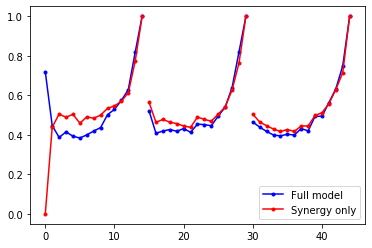

In [315]:
(y,x) = np.histogram(data[data.type==1].y,np.array(range(46))-0.5)
y = y/max(y)
plt.plot(range(0,15),y[0:15],'b.-',label="Full model");
plt.plot(range(15,30),y[15:30],'b.-');
plt.plot(range(30,45),y[30:45],'b.-');
(y,x) = np.histogram(data[data.type==2].y,np.array(range(46))-0.5)
y = y/max(y)
plt.plot(range(0,15),y[0:15],'r.-',label="Synergy only");
plt.plot(range(15,30),y[15:30],'r.-');
plt.plot(range(30,45),y[30:45],'r.-');
plt.legend(loc=4)
plt.show()

In [49]:
# Playground for ranking:
a = np.array([1,5,2,9,3])
b = len(b)-a.argsort().argsort()-1
b

array([4, 1, 3, 0, 2], dtype=int64)

In [ ]:
# Playground for iterating through a list of lists
colorStats = {'W':0, 'U':0, 'B':0, 'R':0, 'G':0}
colorData = [['W'] , ['W','B'], ['U']]
for subList in colorData:
    for item in subList:
        colorStats[item] += 1
    
colorStats

In [ ]:
# Playground for subsetting and quering

possible = np.array([3,5,15,28])
# nameList.iloc[possible].rarity.str[0]=='u' # A good stub to work with rarity
print(nameList.iloc[possible].colors)

condition = list('W' in color for color in nameList.iloc[possible].colors)
print(condition)

possible[condition]

In [20]:
# --- Naive bot (drafts like a 5-years-old)
class RaredraftBot(object):
    def __init__(self,nameList):
        self.nameList = nameList # a list with 'Name' column, containing the names
        
    def rank_pack(self,longVector):
        nCards = int(len(longVector)/2)
        collection = longVector[0:nCards]
        pack = longVector[nCards:]
        
        # - Analyze collection:
        colorStats = {'W':0, 'U':0, 'B':0, 'R':0, 'G':0}
        for subList in list(color for color in self.nameList.iloc[np.nonzero(collection)[0]].colors):
            for item in subList:
                colorStats[item] += 1
        currentColor = max(colorStats, key=colorStats.get) 
        # Comment for this notation of max: Passes each iterable to the key function, 
        # Returns largest iterable based on the return value of the key function
        # print(colorStats, currentColor)
        
        # - Make the pick:
        possibleCards = np.nonzero(packVector)[0]
        rating = np.ones(len(possibleCards)) # ones because existing cards still better than nonexisting
        condition = self.nameList.iloc[possibleCards].rarity.str[0]=='m' # mythics
        rating[condition] += 10 # Cecause rare+on color = 9, and 10 is greater
        condition = self.nameList.iloc[possibleCards].rarity.str[0]=='r' # rares
        rating[condition] += 6 # Because uncommon+oncolor = 5, and 6 is greater
        condition = self.nameList.iloc[possibleCards].rarity.str[0]=='u' # uncommons
        rating[condition] += 3 # because common+uncolor = 2, and 3 is greater
        condition = list(currentColor in color 
                         for color in self.nameList.iloc[possibleCards].colors) # Follow the color
        rating[condition] += 2
        #print(rating)
        
        # botCard = possibleCards[np.argmax(rating)]
        
        preferences = np.zeros(nCards)
        preferences[possibleCards] = rating
        
        return preferences